# “Word Sense Disambiguation” mit Hilfe von Text Mining Methoden

Die Mehrdeutigkeit von Suchbegriffen kann die Korpusbildung erschweren, da wichtige Suchbegriffe auch zu einer großen Anzahl von irrelevanten Dokumenten für das eigene Forschungsprojekt führen können. Das deutsche Wort “Krebs” zum Beispiel, beschreibt eine Krankheit, ist aber auch ein Tier, ein Sternzeichen sowie ein weit verbreiteter Nachname. Um die Bedeutung von Krebs zu bestimmen, braucht es Kontext. Mit Text Mining Methoden kann der Kontext von Suchwörtern mitberücksichtigt und somit die Unterscheidung zwischen relevanten und irrelevanten Dokumenten erleichtert werden. Nachfolgendes Notebook zeigt, wie die Methoden des Topic Modeling (Gensim Library) in Kombination mit der Jensen-Shannon (JS) Distanz genutzt werden können, um semantisch ähnlich Inhalte zu automatisch zu erkennen und zu gruppieren. 

Word Sense Disambiguation (WSD) aus dem Bereich Natural Language Processing (NLP) umfasst Methoden, die polysemische Suchbegriffe disambiguieren sollen. WSD kann als Aufgabe beschrieben werden, die richtige Bedeutung mit einem Wort in einem gegebenen Kontext zu assoziieren" (Pasini und Navigli, 2020). WSD-Techniken können wissensbasiert (z. B. auf der Grundlage von Wörterbüchern), überwacht (mit Hilfe von maschinellem Lernen aus manuell annotierten Daten) oder unüberwacht sein. Unüberwachte WSD-Methoden gehen davon aus, dass ähnliche Bedeutungen in ähnlichen Kontexten auftreten (Pal und Saha, 2015; Navigli 2009)

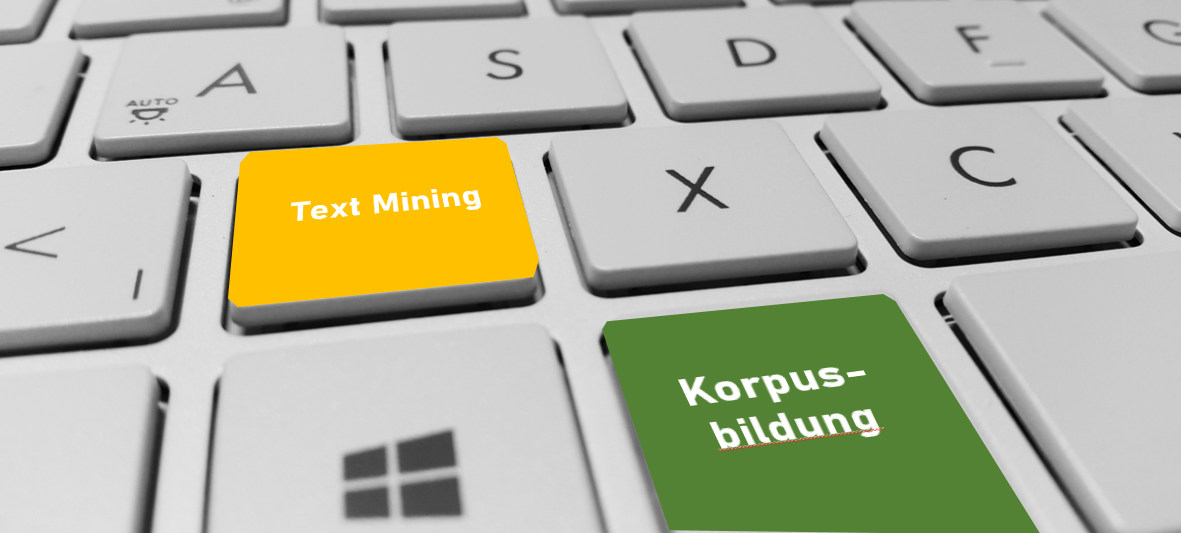

In [1]:
from IPython.display import Image
display(Image("Bilder/cover.png"))

This  work has  been  supported  by  the  European  Union  Horizon  2020  research  and innovation programme under grant 770299 (NewsEye).

## Schritt für Schritt...
* [Importieren eines manuell annotierten Korpus](#1-bullet)
* [Pre-processing and die Spaltung in Trainings- und eines Feedbackkorpus](#2-bullet)
* [Klassifizierung in relevante und irrelevante Artikel](#3-bullet)
* [Anwendung des Modells auf den gesamten Korpus (400 Zeitungsausschnitte) ](#4-bullet)

## Importieren eines manuell annotierten Korpus <a class="anchor" id="1-bullet"></a>

<code style="background:yellow;color:black"> Fügen Sie die CSV Datei "export_krebs_krankheit_12_05_2020_10_52" ein. Dafür geben Sie den Dateiname zwischen die zwei Anführungszeichen bei "df_all = pd.read_csv('')" ein und fügen dem Dateinamen ".csv" hinzu. Klicken Sie zunächst auf das Feld mit dem Code und dann auf "Run", wie im Bild gelb hervorgehoben. </code> 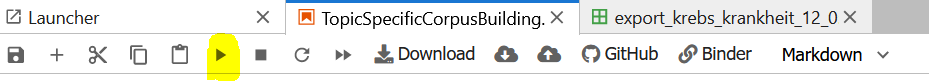

In [30]:
import pandas as pd
import re
import re, numpy as np, pandas as pd
import csv
from pprint import pprint
from IPython.display import display
get_ipython().magic(u'matplotlib inline')
#import data
df_all = pd.read_csv('export_krebs_krankheit_12_05_2020_10_52.csv')
print('Tabelle 1: Annotierter Korpus mit Metadaten.')
df_all.head()

Tabelle 1: Annotierter Korpus mit Metadaten.


,id,language,date,newspaper_id,iiif_url,relevancy,text
0,innsbrucker_nachrichten_ibn19330302_article_64,de,1933-03-02T00:00:00Z,innsbrucker_nachrichten,https://platform.newseye.eu/iiif/innsbrucker_n...,0,"TU. Prag, 2. März. Der vom Prager Abgeordneten..."
1,innsbrucker_nachrichten_ibn18950729_article_51,de,1895-07-29T00:00:00Z,innsbrucker_nachrichten,https://platform.newseye.eu/iiif/innsbrucker_n...,0,Der Kupferstich des Büchleins zeigt ihn uns\ni...
2,illustrierte_kronen_zeitung_krz19170203_articl...,de,1917-02-03T00:00:00Z,illustrierte_kronen_zeitung,https://platform.newseye.eu/iiif/illustrierte_...,0,Frau Krebs ist seit vielen Jahren Offizierswit...
3,illustrierte_kronen_zeitung_krz19390805_articl...,de,1939-08-05T00:00:00Z,illustrierte_kronen_zeitung,https://platform.newseye.eu/iiif/illustrierte_...,0,berg begab sich Generalfeldmarschall Göring im...
4,illustrierte_kronen_zeitung_krz19220410_articl...,de,1922-04-10T00:00:00Z,illustrierte_kronen_zeitung,https://platform.newseye.eu/iiif/illustrierte_...,0,"doch nur so weit, daß es sich eben noch geschm..."


In [3]:
df = pd.read_csv('export_krebs_krankheit_12_05_2020_10_52.csv', usecols = ['text','relevancy'])
caption_content = 'Tabelle 2: Text mit Relevanzlables (3 = relevant; 0 = irrelevant).'
display(df[22:24].style.set_caption(caption_content).hide_index())

relevancy,text
0,"[Ein Fest im Wienerwalde.] Ein Comité, an dessen Spitze Herr Franz Krebs. Vorstand der Section „Wienerwald“ des Oesterreichischen Touristen=Clubs, steht, veranstaltet Sonntag den 25.d. in Eichgraben ein Wald= und Wiesenfest zum Besten der Weihnachtsbetheilung armer Kinder des Wienerwaldes und zur Fertigstellung der Capelle in Eichgraben. Karten sind zu haben bei den Herren C. Taborsky, I., Operngasse Nr. 10, P. Schischmanian, VII., Mariahilferstraße Nr. 70, und Franz Krebs, VII., Lerchenfelderstraße Nr. 73. Cassier des Festes ist Herr Wilhelm Prix, Buchhalter der Niederösterreichischen Landes=Hypotheken=Anstalt, Hutten Nr. 18 (Post Rekawinkel), wohin Spenden zu richten wären."
3,"(Krebsgebiete und Krebshäuser.) Ein Londoner Arzt, der sich viele Jahre mit der Krebskrankheit beschäftigt hat, schreibt an die „Pall Mall Gazette“: „Dr. Haviland hat bewiesen, dass der Krebs eine Krankheit der umgebenden Verhältnisse ist. Es wird jetzt zugegeben, dass es in Ländern Krebs=Gebiete und in manchen Städten Krebsstraßen und Krebshäuser gibt. Ich habe mich zehn Jahre lang mit dieser Sache befasst und bin überzeugt, dass der Krebs von einem Bacillus herrührt, der eine sehr lange Incubations=Periode hat. Dieser Bacillus haust in niedrig gelegenem, sumpfigem Boden und an den Ufern der Flüsse, besonders derjenigen, die ihre Ufer überschreiten. In der Schweiz gibt es „Krebs=Dörfer“, in denen 70 Procent der Bewohner an Krebs sterben“."


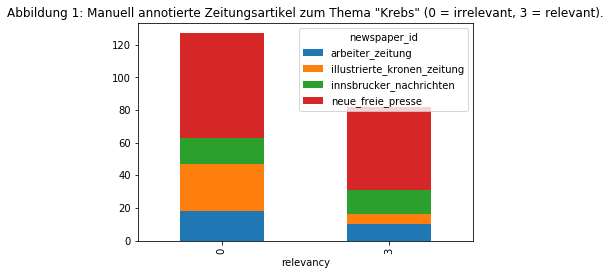

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
df_newspaper = pd.read_csv('export_krebs_krankheit_12_05_2020_10_52.csv')
fig = df_newspaper.groupby(['relevancy','newspaper_id']).size().unstack().plot(kind='bar',stacked=True)
plt.title('Abbildung 1: Manuell annotierte Zeitungsartikel zum Thema "Krebs" (0 = irrelevant, 3 = relevant).')
plt.show()

### Pre-processing and die Spaltung in Trainings- und eines Feedbackkorpus <a class="anchor" id="2-bullet"></a>

Bevor Textmining-Methoden angewendet werden konnten, wurde die Sammlung bereinigt, vorverarbeitet und in einen Trainings- und einen Feedback-/Testkorpus aufgeteilt. Das Pre-Processing ist wichtig, da Interpunktion oder Sonderzeichen für die weitere Analyse in der Regel nicht benötigt werden. Das Gleiche gilt für Wörter wie *und*, *oder*, *mit* und ähnliche, die nicht als wichtiger Kontext betrachtet werden können. Aus diesem Grund werden wir im nächsten Schritt nur jene Wörter beibehalten, die als wichtiger Inhalt für das Thema Krebskrankheit angesehen werden.

##### Reinigen, tokenisieren und stemmen

Mithilfe des NLTK-Pakets (Natural Language Toolkit) werden wir den Text bereinigen (Interpunktion wird entfernt, alle Wörter werden kleingeschrieben) und in Token umwandeln (der Text wird in einzelne sprachliche Einheiten zerlegt). Außerdem werden wir Stoppwörter entfernt und die Wörter stemmen (flektierte Wörter auf ihren Wortstamm reduziert). Ein weiterer pre-processing Schritt, der angewendet werden könnte, ist die Lemmatisierung (Umwandlung von Wörtern in ihre Lemmaform/Lexeme). In diesem Notebook wird jedoch ein deutschsprachigen Stemmer verwendet, da dieser weniger Verarbeitungsaufwand erfordert (kein Part-of-Speech-Tagging erforderlich). Wir haben jedoch die Liste der deutschen Stoppwörter aus dem NLTK-Paket erweitert. Eine längere Liste mit deutschen Stoppwörtern wurde von https://countwordsfree.com/stopwords/german abgerufen und der bestehenden Datei hinzugefügt.

In [5]:
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk import FreqDist

#functions to clean and tokenize the data
def initial_clean(text):
    text = re.sub(r'[^\w\s]','',text)
    text = text.lower() 
    text = nltk.word_tokenize(text, language = 'german')
    return text

#remove stop words
nltk.download('stopwords')
nltk.download('punkt')

stop_words = stopwords.words('german')
#add stop words manually
stop_words.extend(["a", "ab","aber","ach","acht","achte","achten","achter","achtes","ag","alle","allein","allem","allen","aller","allerdings","alles","allgemeinen","als","also","am","an","andere","anderen","andern","anders","au","auch","auf","aus","ausser","außer","ausserdem","außerdem","b","bald","bei","beide","beiden","beim","beispiel","bekannt","bereits","besonders","besser","besten","bin","bis","bisher","bist","c","d","da","dabei","dadurch","dafür","dagegen","daher","dahin","dahinter","damals","damit","danach","daneben","dank","dann","daran","darauf","daraus","darf","darfst","darin","darüber","darum","darunter","das","dasein","daselbst","dass","daß","dasselbe","davon","davor","dazu","dazwischen","dein","deine","deinem","deiner","dem","dementsprechend","demgegenüber","demgemäss","demgemäß","demselben","demzufolge","den","denen","denn","denselben","der","deren","derjenige","derjenigen","dermassen","dermaßen","derselbe","derselben","des","deshalb","desselben","dessen","deswegen","d.h","dich","die","diejenige","diejenigen","dies","diese","dieselbe","dieselben","diesem","diesen","dieser","dieses","dir","doch","dort","drei","drin","dritte","dritten","dritter","drittes","du","durch","durchaus","dürfen","dürft","durfte","durften","e","eben","ebenso","ehrlich","ei","ei,","eigen","eigene","eigenen","eigener","eigenes","ein","einander","eine","einem","einen","einer","eines","einige","einigen","einiger","einiges","einmal","eins","elf","en","ende","endlich","entweder","er","Ernst","erst","erste","ersten","erster","erstes","es","etwa","etwas","euch","f","früher","fünf","fünfte","fünften","fünfter","fünftes","für","g","gab","ganz","ganze","ganzen","ganzer","ganzes","gar","gedurft","gegen","gegenüber","gehabt","gehen","geht","gekannt","gekonnt","gemacht","gemocht","gemusst","genug","gerade","gern","gesagt","geschweige","gewesen","gewollt","geworden","gibt","ging","gleich","gott","gross","groß","grosse","große","grossen","großen","grosser","großer","grosses","großes","gut","gute","guter","gutes","h","habe","haben","habt","hast","hat","hatte","hätte","hatten","hätten","heisst","her","heute","hier","hin","hinter","hoch","i","ich","ihm","ihn","ihnen","ihr","ihre","ihrem","ihren","ihrer","ihres","im","immer","in","indem","infolgedessen","ins","irgend","ist","j","ja","jahr","jahre","jahren","je","jede","jedem","jeden","jeder","jedermann","jedermanns","jedoch","jemand","jemandem","jemanden","jene","jenem","jenen","jener","jenes","jetzt","k","kam","kann","kannst","kaum","kein","keine","keinem","keinen","keiner","kleine","kleinen","kleiner","kleines","kommen","kommt","können","könnt","konnte","könnte","konnten","kurz","l","lang","lange","leicht","leide","lieber","los","m","machen","macht","machte","mag","magst","mahn","man","manche","manchem","manchen","mancher","manches","mann","mehr","mein","meine","meinem","meinen","meiner","meines","mensch","menschen","mich","mir","mit","mittel","mochte","möchte","mochten","mögen","möglich","mögt","morgen","muss","muß","müssen","musst","müsst","musste","mussten","n","na","nach","nachdem","nahm","natürlich","neben","nein","neue","neuen","neun","neunte","neunten","neunter","neuntes","nicht","nichts","nie","niemand","niemandem","niemanden","noch","nun","nur","o","ob","oben","oder","offen","oft","ohne","Ordnung","p","q","r","recht","rechte","rechten","rechter","rechtes","richtig","rund","s","sa","sache","sagt","sagte","sah","satt","schlecht","Schluss","schon","sechs","sechste","sechsten","sechster","sechstes","sehr","sei","seid","seien","sein","seine","seinem","seinen","seiner","seines","seit","seitdem","selbst","sich","sie","sieben","siebente","siebenten","siebenter","siebentes","sind","so","solang","solche","solchem","solchen","solcher","solches","soll","sollen","sollte","sollten","sondern","sonst","sowie","später","statt","t","tag","tage","tagen","tat","teil","tel","tritt","trotzdem","tun","u","über","überhaupt","übrigens","uhr","um","und","und?","uns","unser","unsere","unserer","unter","v","vergangenen","viel","viele","vielem","vielen","vielleicht","vier","vierte","vierten","vierter","viertes","vom","von","vor","w","wahr?","während","währenddem","währenddessen","wann","war","wäre","waren","wart","warum","was","wegen","weil","weit","weiter","weitere","weiteren","weiteres","welche","welchem","welchen","welcher","welches","wem","wen","wenig","wenige","weniger","weniges","wenigstens","wenn","wer","werde","werden","werdet","wessen","wie","wieder","will","willst","wir","wird","wirklich","wirst","wo","wohl","wollen","wollt","wollte","wollten","worden","wurde","würde","wurden","würden","x","y","z","z.b","zehn","zehnte","zehnten","zehnter","zehntes","zeit","zu","zuerst","zugleich","zum","zunächst","zur","zurück","zusammen","zwanzig","zwar","zwei","zweite","zweiten","zweiter","zweites","zwischen","zwölf","euer","eure","hattest","hattet","jedes","mußt","müßt","sollst","sollt","soweit","weshalb","wieso","woher","wohin"])
def remove_stop_words(text):
    return [word for word in text if word not in stop_words]

#stemming
stemmer = SnowballStemmer("german")
def stem_words(text):
    try:
        text = [stemmer.stem(word) for word in text]
        text = [word for word in text if len(word) > 1] 
    except IndexError: 
        pass
    return text

#apllying all functions 
def apply_all(text):
    return stem_words(remove_stop_words(initial_clean(text)))

df['tokenized'] = df['text'].apply(apply_all) 

caption_content='Tabelle 2: Relevany, Originaltext und Tokens.'
display(df[12:14].style.set_caption(caption_content).hide_index())


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\c62255\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\c62255\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


relevancy,text,tokenized
0,"„Hab' i a net g'sagt. Kriegst hernach an Brief und gehst damit zum „Roten Krebs“, wo der Poldl eing stellt war, sagst an schön' Gruß von mir und i tät bitten, der Wirt soll täuscheln. Der Poldl bleibt wieder da und du bist drent a auf an guten Platz. Is a Spezi, der „Rote Krebs“, und wird mir's nit abschlagen. Alsdern, hast scho' Mittagessen kriegt, na? Dann schau dazu!“","['net', 'gsagt', 'krieg', 'hernach', 'brief', 'gehst', 'rot', 'kreb', 'poldl', 'eing', 'stellt', 'sagst', 'schon', 'gruss', 'tat', 'bitt', 'wirt', 'tauscheln', 'poldl', 'bleibt', 'drent', 'gut', 'platz', 'is', 'spezi', 'rot', 'kreb', 'mir', 'nit', 'abschlag', 'alsd', 'scho', 'mittagess', 'kriegt', 'schau']"
0,"mildert Husten, löst Schleim, auf die Lunge wohltuend! Alle Apotheken führen Ihn! Auch für Kinder! Orig.-Packung zu RM —.93 und 1.54 Depot: „Krebs-Apotheke“, Wien, I., Hoher Markt 8, Abt. 568","['mildert', 'hust', 'lost', 'schleim', 'lung', 'wohltuend', 'apothek', 'fuhr', 'kind', 'origpack', 'rm', '93', '154', 'depot', 'krebsapothek', 'wien', 'hoh', 'markt', 'abt', '568']"


In einem weiteren Schritt wird die Sammlung in ein Trainings- und Testkorpus zu unterteilt. Damit erhalten wir eine Reihe von Dokumenten (Trainingskorpus), um den Algorithmus zu trainieren, und eine Reihe von Dokumenten (Testkorpus), um die Effizienz der gewählten Methoden zu testen. 

##### Training- und Testkorpus

Um die Sammlung in ein Trainings- und ein Testkorpus aufzuteilen, wurde die Funktion numpy.random.rand() verwendet, um ein Array mit einer bestimmten Form zu erstellen und es mit Zufallswerten zu füllen. Dies ermöglichte es, eine gute Mischung aus relevanten und nicht relevanten Artikeln in jedem der Korpora zu erhalten (Abbildung 2). Da diese Funktion auf dem Zufallsprinzip beruht und die Aufteilung der Korpora bei jedem Aufruf variieren kann, wurde ein Zufallswert gesetzt, um reproduzierbare Aufrufe zu erzeugen. Folglich sind alle Zufallszahlen, die nach dem Setzen des Seeds erzeugt werden, auf jeder Maschine gleich.

In [6]:
#create testing and training corpus
np.random.seed(1)
msk = np.random.rand(len(df)) < 0.599
train_df = df[msk]
train_df.reset_index(drop=True,inplace=True)
test_df = df[~msk]
test_df.reset_index(drop=True,inplace=True)

Der Trainingskorpus enthält 124 Artikel, 45 sind relevant und 79 irrelevant.
Der Testkoprus enthält 85 Artikel, 37 sind relevant und 48 irrelevant.


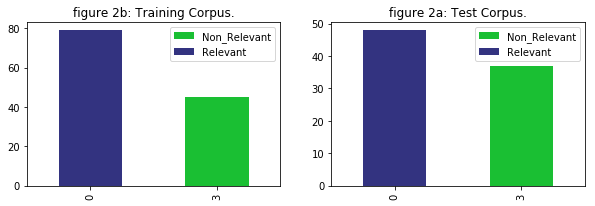

In [7]:
#plot the result
my_colors = [(0.20,0.200,0.50), (0.100, 0.75, 0.200)] #set colors
fig, axes = plt.subplots(1,2,figsize=(10,3))
test_df.relevancy.value_counts().plot(kind='bar', color = (0.100, 0.75, 0.20), ax=axes[1])
test_df.relevancy.value_counts().plot(kind='bar', color = my_colors, ax=axes[1])
train_df.relevancy.value_counts().plot(kind='bar', color = (0.100, 0.75, 0.20), ax=axes[0])
train_df.relevancy.value_counts().plot(kind='bar', color = my_colors, ax=axes[0])
axes[1].legend(['Non_Relevant', 'Relevant'])
axes[0].legend(['Non_Relevant', 'Relevant'])
axes[1].title.set_text('figure 2a: Test Corpus.')
axes[0].title.set_text('figure 2b: Training Corpus.')
print(f"Der Trainingskorpus enthält {len(train_df)} Artikel, {train_df.relevancy.value_counts()[3]} sind relevant und {train_df.relevancy.value_counts()[0]} irrelevant.")
print(f"Der Testkoprus enthält {len(test_df)} Artikel, {test_df.relevancy.value_counts()[3]} sind relevant und {test_df.relevancy.value_counts()[0]} irrelevant.") 

### Klassifizierung in relevante und irrelevante Artikel <a class="anchor" id="3-bullet"></a>

Um Wörter und ähnliche Ausdrücke zu gruppieren, die relevante oder irrelevante Dokumente am besten charakterisieren, und um jeden Artikel mit Informationen über seine Themenverteilung zu versehen, wird ein Topic Modeling Altgorithmus (LDA) trainiert. Die Jensen-Shannon Distanz hingegen wird verwendet, um die Ähnlichkeit zwischen der Themenverteilung der Dokumente zu messen. Die Kombination von LDA und JSD hat Vorteile gegenüber Textklassifikatoren, da auch für hochkomplexe Sammlung gute Ergebnisse erziehlt werden können. Die Grenzen zwischen relevanten und nicht relevanten Artikeln ist bei vielen mehrdeutigen Begriffen sehr wage. Mit LDA in Kombination mit JSD kann diese Komplexität bewältigt werden, indem der Dateninput für die endgültige Klassifizierung eines ungesehenen Artikels auf die 10 ähnlichsten Artikel eingrenzen. Dies bedeutet, dass nur die ähnlichsten Artikel als Grundlage für die Klassifizierung eines ungesehenen Artikels herangezogen werden.

#### Trainieren des Topic Modeling Algorithmus

Topic Modelle beruhen auf der Annahme, dass Texten in natürlicher Sprache eine relativ kleine Menge latenter oder verborgener Themen zugrunde liegt, wobei ein Wort zu mehreren Themen gehören kann. Themenmodelle verwenden die so genannte Bag-of-Words-Annahme innerhalb eines Dokuments bzw. sie gruppieren statistisch signifikante Wörter innerhalb eines bestimmten Korpus. Wie von (Blei, Ng und Jordan 2003) beschrieben, können Dokumente "als zufällige Mischungen über latente Themen dargestellt werden, wobei jedes Thema durch eine Verteilung über Wörter charakterisiert ist". Die Themenmodellierung wird für verschiedene Zwecke eingesetzt: um einen Koprpus besser zu verstehen (Zosa et al. 2020), um Diskursdynamik zu erfassen (Marjanen et al. 2020), um einen besseren Einblick in die Art oder das Genre von Dokumenten in einem Korpus zu erhalten (Oberbichler 2021), um die Entwicklung von Themen und Trends in mehrsprachigen Sammlungen zu erfassen (Zosa und Granroth-Wilding 2019) oder um verschiedene Korpora zu vergleichen (Lu, Henchion und Namee 2019).


Jeder dieser Anwendungsbereiche benötigt unterschiedliche Parameter. Während Methoden zur automatischen Bestimmung der Themenanzahl in einigen Fällen hilfreich sein können (Zhao et al. 2015) (O'Callaghan et al. 2015), ist das genaue Lesen einer beträchtlichen Menge von Dokumenten nach wie vor am zuverlässigsten.

Wir verwenden hier die Python-Bibliothek *Gensim*, um die Topic Modelle zu trainieren. Gensim ist eine Bibliothek, die für die Themenmodellierung, die Dokumentenindexierung als auch die Ähnlichkeitssuche verwendet wird. Alle Algorithmen sind speicher- und sprachunabhängig sowie unüberwacht, was bedeutet, dass keine menschliche Eingabe erforderlich ist.

In [8]:
import gensim
from gensim.models import LdaModel
from gensim import parsing, corpora, matutils, interfaces, models, utils
import gensim.corpora as corpora
import gensim, spacy, logging, warnings
from gensim.models import CoherenceModel
from matplotlib import pyplot as plt
from wordcloud import WordCloud

#function to train the topic model
def train_lda(data):
    num_topics = 250
    dictionary = corpora.Dictionary(data['tokenized'])
    corpus = [dictionary.doc2bow(doc) for doc in data['tokenized']]
    lda = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary,
                   alpha=0.2e-2, eta=1e-2, minimum_probability=0.0, passes=5, iterations=200, update_every=1)
    return dictionary,corpus,lda

#apply function and check results
dictionary,corpus,lda = train_lda(train_df)


C:\Users\c62255\AppData\Roaming\Python\Python37\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


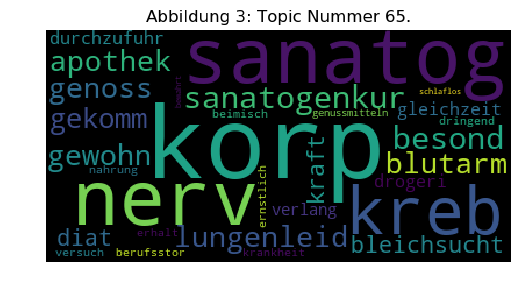

In [9]:
# plot word cloud
plt.figure(dpi=100)
plt.imshow(WordCloud(max_words=30).fit_words(dict(lda.show_topic(65, 200))))
plt.axis("off")
plt.title("Abbildung 3: Topic Nummer 65.")
plt.show()

##### Dominante Topics ermitteln

Nach dem Training des Modells sollte geprüft werden, wie gut diese Themen in relevante und nicht relevante Artikel unterteilt werden konnten. Nicht alle Themen haben die gleiche Dominanz innerhalb eines Textes. Um zu verstehen, welches Thema in einem Dokument am dominantesten ist, werden die Themen mit der höchsten Gewichtung für ein Dokument ermittel.

In [10]:
def format_topics_texts(ldamodel=None, corpus=corpus, relevancy=df['relevancy']):
    sent_topics_df = pd.DataFrame()

    #get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list   
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        for s, (topic_num, prop_topic) in enumerate(row):
            if s == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    #add relevancy to the end of the output
    contents = pd.Series(relevancy)
    
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_texts(ldamodel=lda, corpus=corpus, relevancy=df['relevancy'])

In [11]:
#format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Relevancy']
caption_content= 'Tabelle 2: Dominante Topics eines jeden Artikels, topic Keyörter und die Relevanz der Artikel.'
display(df_dominant_topic[18:23].style.set_table_attributes("style='display:block'").set_caption(caption_content).hide_index())

Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Relevancy
18,65.000000,0.861600,"korp, sanatog, nerv, kreb, sanatogenkur, besond, lungenleid, apothek, blutarm, genoss",3
19,56.000000,0.921200,"nr, kreb, café, woll, famili, geb, restaurant, taborstrass, tradition, wissenschaftl",3
20,243.000000,0.986000,"apothek, markt, tarnow, brunn, wien, kreb, vermog, eder, roth, 50",3
21,115.000000,0.988300,"mos, kreb, gewahlt, frey, klubrat, schriftfuhr, brenn, koutny, okmann, skura",0
22,206.000000,0.997400,"erfind, deutsch, vortrag, leid, kreb, volk, kampf, chirurg, aussicht, zahlreich",0


Wie in [Tabelle 3](#table-3) zu sehen ist, stellt das Topic 65 [Abbildung 3](#figure-3) eindeutig diesen Artikel dar, in dem es am dominantesten ist.

In [12]:
article_df_1 = train_df['text'][65]
article_df_1 = pd.DataFrame(np.column_stack([article_df_1]), 
                              columns=['Der Text, der überwiegend von Topic 56 repräsentiert wird'])
article_df_1 = article_df_1.apply(lambda x: x[:300])
caption_content = "Tabelle 3: Der Text, der überwiegend von Topic 56 repräsentiert wird"
display(article_df_1.style.set_caption(caption_content).hide_index())

"Der Text, der überwiegend von Topic 56 repräsentiert wird"
"Ein französischer Arzt, ein Professor der Chirurgie an der medicinischen Facultät in Reims, dessen Name gleichfalls verschwiegen bleibe, unterstand sich, die Frage zu lösen. Seine That war allerdings nicht ganz so niederträchtig wie die des Gewährsmannes Cornil's, auch nicht so albern und zugleich schändlich wie die von Curel's Donnat. Er übertrug den Krebs auf Paralytiker im Endzustande des tiefsten Irrsinns, das heißt auf Kranke, deren Unheilbarkeit ungleich zweifelloser ist als die der Lungenschwindsüchtigen, und die dennoch lang genug leben, um die Entwicklung der Geschwulst zu ermöglichen. Seine Versuche hatten bejahende Ergebnisse, und es ist nunmehr sestgestellt, daß gewisse bösartige Geschwülste unter Umständen von einem Menschen auf den anderen künstlich übertragen werden können. Trotz mildernder Umstände wurde auch die Handlung des Reimser Professors sehr hart beurtheilt. Seine eigenen Schüler verhängten den Verruf über ihn, und dem Strafrichter entging er nur durch Einflüsse, wie auch Curel sie im „Neuen Götzen“ ins Werk setzt."


##### Visualisierung der Verknüpfung von dominaten Themen und Relevanzleveln

Um zu sehen, wie gut die dominanten Themen auf relevante (3) und nicht relevante (0) Artikel verteilt sind, erstellen wir eine Netzwerkvisualisierung mit dem Python-Paket *NetworkX*. NetworkX wird hauptsächlich für die Erstellung, Manipulation und Untersuchung der Struktur, Dynamik und Funktionen komplexer Netzwerke verwendet. Anhand dieser Visualisierung lässt sich erkennen, wie effektiv das Modell trainiert wurde. Für das Netzwerk werden das dominanteste Thema sowie das Relevanzlabel für jeden Zeitungsausschnitt miteinander in Verbindung gebracht.

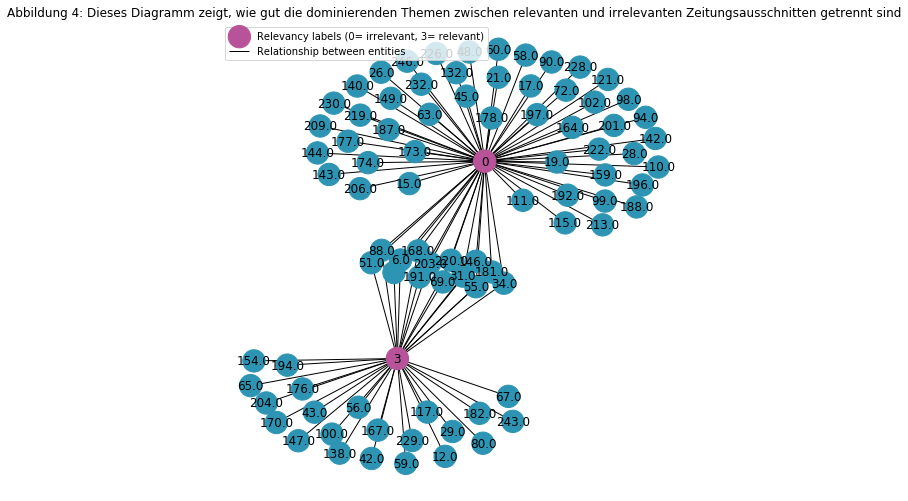

In [13]:
import networkx as nx
import seaborn as sns
import sys

#create a list with topics and the relevancy
df_dominant_topic.to_csv('topic_relevancy.csv')
import csv
with open('topic_relevancy.csv',  encoding="utf8") as infile:
    reader = csv.reader(infile)    
    csv_data = list(reader)
df_dominant_topics= pd.read_csv('topic_relevancy.csv', usecols = ['Dominant_Topic', 'Relevancy'])
list_topic = []
for key in csv_data: 
    list_topic.append(key[2])
topic = list_topic[1:]

list_relevancy = []
for key in csv_data:
    list_relevancy.append(key[5])
relevance = list_relevancy[1:] 


#build a dataframe with 4 connections
df = pd.DataFrame({ 'from': relevance, 'to': topic})

#build the graph 
plt.figure(figsize=(6.5,6.5))
G = nx.from_pandas_edgelist(df, 'from', 'to')
color_map = []
for node in G:
    if node == "3":
        color_map.append('#b85399')
    if node == "0":
        color_map.append('#b85399')
    else: 
        color_map.append('#2d95b3') 


        
#plot it 
nx.draw(G, with_labels=True, node_color=color_map, node_size=500)
plt.legend(('Relevancy labels (0= irrelevant, 3= relevant)', 'Relationship between entities'),
           loc='upper left')
plt.title('Abbildung 4: Dieses Diagramm zeigt, wie gut die dominierenden Themen zwischen relevanten und irrelevanten Zeitungsausschnitten getrennt sind')
plt.show()



#### Semantisch ähnliche Artikel finden

Im nächsten Schritt wird die Jensen-Shannon-Distanz (JS) verwendet, um die Ähnlichkeit zwischen der Themenverteilung der Dokumente aus dem Trainingskorpus und jenen aus dem Testkorpus zu messen. Es wird davon ausgegangen, dass Artikel mit ähnlichen Inhalten auch als solche erkannt werden. 

In [14]:
from scipy.stats import entropy

#JS distance functions
def jensen_shannon(query, matrix):
    p = query[None,:].T 
    q = matrix.T 
    m = 0.5*(p + q)
    return np.sqrt(0.5*(entropy(p,m) + entropy(q,m)))
def get_most_similar_documents(query,matrix,k=10):
    sims = jensen_shannon(query,matrix) 
    return sims.argsort()[:k]

#most similar articles
bow = dictionary.doc2bow(test_df.iloc[11,2])
doc_distribution = np.array([tup[1] for tup in lda.get_document_topics(bow=bow)])
doc_topic_dist = np.stack([np.array([tup[1] for tup in lst]) for lst in lda[corpus]])
doc_topic_dist.shape
sim_ids = get_most_similar_documents(doc_distribution,doc_topic_dist)
similar_df = train_df[train_df.index.isin(sim_ids)]

Mit der Hilfe der JS-Distanz wurde die Themenverteilung jedes neuen Artikels (aus dem Testkorpus) mit der Themenverteilung jedes Artikels im Trainingkorpus verglichen. Auf diese Weise wurden die 10 ähnlichsten Artikel aus dem Trainingskorpus abgerufen. 

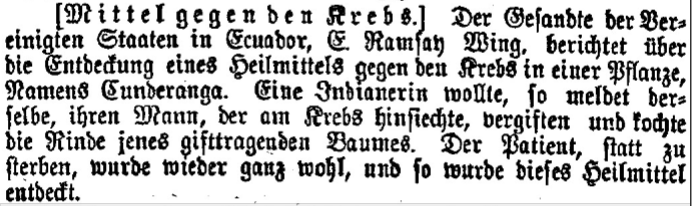

In [15]:
from IPython.display import Image, display
metadata_1={
    "metadata":{
        "module": "object",
        "object": {
          "type": "image",
          "source": [
            "Abbildung 5: Neue Freie Presse, 02.07.1871, p. 24.",
          ]
        }
    }
}
display(Image("Bilder/artikel.png"), metadata=metadata_1)

[Tabelle 4](#table-4) zeigt die zehn ähnlichsten Artikel für den Zeitungsartikel aus "Neue Freie Presse" vom 02.07.1871. 

In [16]:
similar_df = similar_df.drop(['tokenized'], axis =1)
similar_df['text'] = similar_df['text'].apply(lambda x: x[:100])
similar_df.rename(columns={'text': 'Die zehn ähnlichsten Artikel aus dem Trainingskorpus für den ungesehenen Artikel aus Abbildung ...'}, inplace=True)
caption_content= 'Tabelle 4: Die zehn ähnlichsten Artikel aus dem Trainingskorpus für den ungesehenen Artikel aus Abbildung'
display(similar_df.style.set_caption(caption_content)).hide_index())

,relevancy,Die zehn ähnlichsten Artikel aus dem Trainingskorpus für den ungesehenen Artikel aus Abbildung ...
34,0,„Kronen Feilanig In den letzten Tagen sind uns von den Herren und Damen folgende Spenden zugekommen:
36,0,"Die Elite des österreichischen Kraftsports trifft sich in der ersten Klasse, wo zwar nur acht Verein"
47,3,"Krankheiten, Krebs, Geschwülften, Wassersucht, Hämorrhoiden 2c., ohne Operationen oder Verstümmelung"
57,3,"[Eine angebliche medicinische Entdeckung.] Der Pariser „Figaro“ meldete heute, der Pariser Dr. Bra h"
76,3,"einem Schlage wird uns hier verständlich, wie es möglich ist, daß ein Krebs sich mit großer Geschwin"
84,3,"zum erstenmal ausgeführt. Bei Krebs hat man sie schon zweimal versucht, doch ist hier diese Operat"
85,3,"dieser an sich immer gefährlichen, aber meist unausweichlichen und oft lebensrettenden Operationen."
91,0,"Wien, 8. Mai. [Hof= und Personal=Nachrichten.] Erzherzog Ludwig Victor besuchte gestern die Möbelind"
98,3,"Ob der Krebs in Familien erblich ist, ist zweifelhaft. Tatsache ist, daß der Krebs in den Kulturländ"
101,3,"[Die Preisausschreibung für ein Heilmittel gegen den Krebs.] Sir William Veno, ein Apotheker aus Man"


#### Klassifikation in relevant und irrelevant

Nun durchläuft jeder Artikel aus dem Testkorpus eine Schleife, in der er mit den Artikeln im Trainingskoprus verglichen und schließlich einer der Kategorien (relevant oder nicht relevant) zugeordnet wird. Wenn 60 Prozent der ähnlichsten Artikel ursprünglich als relevant eingestuft wurden, wurde auch der neue Artikel als relevant eingestuft. Andernfalls wurde er als irrelevant eingestuft. In diesem Fall wurde der ungesehene Artikel aus [Abbildung 5](#figure-5) als relevant eingestuft (erste Spalte, dritte Zeile), weil mehr als 60 Prozent der ähnlichsten Artikel ([Tabelle 5](#table-5)) ursprünglich als relevant annotiert waren (= 3).

In [17]:
#lists for the output

text_relevant = []
number_relevant = []
text_non_relevant = []
number_non_relevant = []

index = 0
#loop for the classification of each article
while index < len(test_df) -1:
    index +=1
    new_bow = dictionary.doc2bow(test_df.iloc[index,2])
    new_doc_distribution = np.array([tup[1] for tup in lda.get_document_topics(bow=new_bow)])
    doc_topic_dist = np.stack([np.array([tup[1] for tup in lst]) for lst in lda[corpus]])
    doc_topic_dist.shape
    most_sim_ids = get_most_similar_documents(new_doc_distribution,doc_topic_dist)
    most_similar_df = train_df[train_df.index.isin(most_sim_ids)]
    relevant = []
    if sum(most_similar_df['relevancy']) > 17: 
        text_relevant.append(test_df.iloc[index,1])
        number_relevant.append(test_df.iloc[index,0])
    else:
        text_non_relevant.append(test_df.iloc[index,1])
        number_non_relevant.append(test_df.iloc[index,0])

#dataframe with results

df_relevant = pd.DataFrame(np.column_stack([text_relevant, number_relevant]), 
                               columns=['Relevant_Text', 'Real_Relevancy'])

df_non_relevant = pd.DataFrame(np.column_stack([text_non_relevant, number_non_relevant]), 
                               columns=['Unrelevant_Text', 'Real_Relevancy'])

df_results = pd.concat([df_relevant,df_non_relevant], ignore_index=True, axis=1)
df_results.columns=['Diese Texte wurden als relevant klassifiziert', '3','Diese Texte wurden als irrelevant klassifiziert', '0']


df_results['Diese Texte wurden als relevant klassifiziert'][0:20] = df_results['Diese Texte wurden als relevant klassifiziert'][0:20].apply(lambda x: x[:50])
df_results['Diese Texte wurden als irrelevant klassifiziert'][0:20] = df_results['Diese Texte wurden als irrelevant klassifiziert'][0:20].apply(lambda x: x[:50])
caption_content= 'Tabelle 5: Die Artikel werden automatisch in relevante und nicht relevante Artikel gruppiert. Die manuell vergebenen Annotierungen zeigen, ob die Artikel korrekt klassifiziert wurden.'
display(df_results[0:20].style.set_caption(caption_content).hide_index())

Diese Texte wurden als relevant klassifiziert,3,Diese Texte wurden als irrelevant klassifiziert,0
"mildert Husten, löst Schleim, auf die Lunge wohltu",0,der kurzen Darlegung dieses Artikels braucht der L,3
der Kongreß für die Röntgen=Behandlung manchen Fin,3,"underPüllmann-Tee schleimlösend, hustenstillend, A",0
nastik. — Der Krebs der Brustdrüse. — Der Krebs de,3,"Kreis IV: Gasthaus Bürgermeister, Gramatneusiedl.",0
[Mittel gegen den Krebs.] Der Gesandte der Vereini,3,"(Krebsgebiete und Krebshäuser.) Ein Londoner Arzt,",3
"Krebs kommt an allen Obstforten vor, am häufigsten",0,"Wien (1), Schottenring 35, Emil Krebs. Laa= und Fa",0
Schundliteratur den einer unter den modernen Autor,3,"So etwas ist immer Pflaster auf eine Wunde, wenn e",0
— (Die Geschwornen im Februar.) Die heute vorgenom,0,"Elena machte eine ablehnende Bewegung. „Nein, Dros",3
Ein sehr sorgfältig vorbereiteter Vortrag des Leip,3,[Der älteste österreichische Lieutenant.] Heute um,0
zur Verbreitung naturwessenschaftlicher Kenntnisse,3,4. Sektion für den III. und XI. Bezirk im Gemeinde,0
Es wurden Bilder von Geschwülsten krebs artiger Na,3,"Die Truppen, die in der Chausseestraße gegen den D",0


In [18]:
#calculation of correct or incorrect classified results
rev_3 = []
for key in df_results['3']:
    if key == '3':
        rev_3.append(key)
rev_0 = []
for key in df_results['3']:
    if key == '0':
        rev_0.append(key)
non_rev_3 = []
for key in df_results['0']:
    if key == '3':
        non_rev_3.append(key)
non_rev_0 = []
for key in df_results['0']:
    if key == '0':
        non_rev_0.append(key)
result_right = len(non_rev_0) + len(rev_3)
result_wrng = len(non_rev_3) + len(rev_0)
relevant = len(rev_3) / (len(rev_0) + len(rev_3))
irrelevant = len(non_rev_0) / (len(non_rev_0) + len(non_rev_3))
all_ = len(non_rev_3) + len(rev_0) + len(non_rev_0) + len(rev_3)
score = result_right / all_


df_score = pd.DataFrame(np.column_stack([relevant, irrelevant, score]), 
                               columns=['Correct classified relevant articles', 'Correct classified irrelevant articles', 'Total score'])
caption_content= 'table 6: Evaluation of the classification of the articles from the testing corpus.'
display(df_score.style.set_caption(caption_content).hide_index())

Correct classified relevant articles,Correct classified irrelevant articles,Total score
0.843750,0.807692,0.821429


Diese Ergebnisse werden als gut genug für die weitere Verarbeitung angesehen. Der letzte Schritt betrifft den gesamten Korpus, der disambiguiert werden soll.

### Anwendung des Modells auf den gesamten Korpus (400 Zeitungsausschnitte) <a class="anchor" id="4-bullet"></a>

In [19]:
df_all = pd.read_csv('export_krebs_all_25_05_2020_20_00.csv', usecols = ['id','language','date','newspaper_id','iiif_url','text'])
df_all_2 = pd.read_csv('export_krebs_all_25_05_2020_20_00.csv', usecols = ['id','language','date','newspaper_id','iiif_url','text'])
print('Tabelle 7: Gesamter Korpus')
df_all.head()

Tabelle 7: Gesamter Korpus


,id,language,date,newspaper_id,iiif_url,text
0,innsbrucker_nachrichten_ibn19390213_article_900,de,1939-02-13T00:00:00Z,innsbrucker_nachrichten,https://platform.newseye.eu/iiif/innsbrucker_n...,Wichtig ist auch das Auslichten der Kronen. Be...
1,innsbrucker_nachrichten_ibn19130521_article_172,de,1913-05-21T00:00:00Z,innsbrucker_nachrichten,https://platform.newseye.eu/iiif/innsbrucker_n...,In Innsbruck starteten vor dem Korps=Kommando=...
2,illustrierte_kronen_zeitung_krz19110818_articl...,de,1911-08-18T00:00:00Z,illustrierte_kronen_zeitung,https://platform.newseye.eu/iiif/illustrierte_...,Mathias Krebs. Kommabazillus oder Cholerabazil...
3,illustrierte_kronen_zeitung_krz19390413_articl...,de,1939-04-13T00:00:00Z,illustrierte_kronen_zeitung,https://platform.newseye.eu/iiif/illustrierte_...,Kurzmeldungen\nDer Leiter des Fremdenverkehrs ...
4,illustrierte_kronen_zeitung_krz19110625_articl...,de,1911-06-25T00:00:00Z,illustrierte_kronen_zeitung,https://platform.newseye.eu/iiif/illustrierte_...,"S. Mittelbach, Krebs=Apotheke,\nWien, I., Hohe..."


In [20]:
df_all['tokenized'] = df_all['text'].apply(apply_all) 

In [21]:
# first get a list of all words
all_words = [word for item in list(df_all['tokenized']) for word in item]
# use nltk fdist to get a frequency distribution of all words
fdist = FreqDist(all_words)
f"Die Anzahl individueller Worter ist: {len(fdist)}"

'Die Anzahl individueller Worter ist: 11347'

In [22]:
#document length
df_all['doc_len'] = df_all['tokenized'].apply(lambda x: len(x))
doc_lengths = list(df_all['doc_len'])
df_all.drop(labels='doc_len', axis=1, inplace=True)

print(f"Die Sammlung enthält {max(doc_lengths)} Artikel")

Die Sammlung enthält 620 Artikel


In [23]:
df_all = df_all[df_all['tokenized'].map(len) >= 30]
df_all = df_all[df_all['tokenized'].map(type) == list]
df_all.reset_index(drop=True,inplace=True)
print("Die Sammlung enthält nun", len(df_all), "Artikel")

Die Sammlung enthält nun 399 Artikel


In [24]:
def jensen_shannon(query, matrix):
    p = query[None,:].T 
    q = matrix.T 
    m = 0.5*(p + q)
    return np.sqrt(0.5*(entropy(p,m) + entropy(q,m)))

In [25]:
def get_most_similar_documents(query,matrix,k=10):
    sims = jensen_shannon(query,matrix) # list of jensen shannon distances
    return sims.argsort()[:k] # the top k positional index of the smallest Jensen Shannon distances

In [26]:
#create lists for your output
text_relevant = []
number_relevant = []
date_relevant = []
text_non_relevant = []
number_non_relevant = []
language_relevant = []
newspaper_id_relevant = []
iiif_url_relevant = []
id_relevant = []

#find most similar articles and select between relevant and non-relevant

index = 0
while index < len(df_all) -1:
    index +=1
    new_bow = dictionary.doc2bow(df_all.iloc[index,6])
    new_doc_distribution = np.array([tup[1] for tup in lda.get_document_topics(bow=new_bow)])
    doc_topic_dist = np.stack([np.array([tup[1] for tup in lst]) for lst in lda[corpus]])
    doc_topic_dist.shape
    most_sim_ids = get_most_similar_documents(new_doc_distribution,doc_topic_dist)
    most_similar_df = train_df[train_df.index.isin(most_sim_ids)]
    # Calculate 
    if sum(most_similar_df['relevancy']) > 17: 
        text_relevant.append(df_all.iloc[index,5])
        date_relevant.append(df_all.iloc[index,2])
        language_relevant.append(df_all.iloc[index,1])
        newspaper_id_relevant.append(df_all.iloc[index,3])
        iiif_url_relevant.append(df_all.iloc[index,4])
        id_relevant.append(df_all.iloc[index,0])
        
    else:
        text_non_relevant.append(df_all.iloc[index,5])


C:\Users\c62255\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in sqrt
  """


In [27]:
#transform your lists into a dataframe
df_relevant = pd.DataFrame(np.column_stack([text_relevant]), 
                               columns=['Relevanter_Text'])

df_non_relevant = pd.DataFrame(np.column_stack([text_non_relevant]), 
                               columns=['Unrelevanter_Text'])

df_results = pd.concat([df_relevant,df_non_relevant], ignore_index=True, axis=1)
df_results.columns=['Diese Texte wurden als relevant klassifiziert', 'Diese Texte wurden als irrelevant klassifiziert']


df_results['Diese Texte wurden als relevant klassifiziert'][0:5] = df_results['Diese Texte wurden als relevant klassifiziert'][0:5].apply(lambda x: x[:400])
df_results['Diese Texte wurden als irrelevant klassifiziert'][0:5] = df_results['Diese Texte wurden als irrelevant klassifiziert'][0:5].apply(lambda x: x[:400])
caption_content= 'Tabelle 5: Die Artikel werden automatisch in relevante und nicht relevante Artikel gruppiert. Die manuell vergebenen Annotierungen zeigen, ob die Artikel korrekt klassifiziert wurden.'
display(df_results[0:5].style.set_caption(caption_content).hide_index())

Diese Texte wurden als relevant klassifiziert,Diese Texte wurden als irrelevant klassifiziert
"Schon am nächsten Tag erschien in den Geschäften der Auswurf des Lodzer Bettlerpacks: Krüppel, Zigeunerinnen mit verlausten Kindern, Bettler mit furchtbaren Geschwüren und vom Krebs zerfressenen Gesichtern, die das kaufende Publikum im Nu aus den Geschäften verscheuchten. Auf den Notschrei der Geschäftsleute griff die Polizei ein, sperrte die schlimmsten Rädelsführer ein und verhaftete vor allem d","In Innsbruck starteten vor dem Korps=Kommando=Gebäude um 1 Uhr die Herren: Gruppenkommandant Oblt. Adolf Bier 30 Pferdekräfte Raf, Gruppenkommandant=Stellvertreter Ltu. i. d. R. Fritz Weis 18 Pferdekräfte Raf, Oblt. d. E. Graf Salburg 30 Pferdekräfte Mercedes, Ltn. d. R. Willy Swarovsky 18 Pferdekräfte LaurinKlement, Jos. Schatzmann, 24 Pferdelräfte Laurin=Klement, Edmund Landsee 30 Pferdekräfte F"
"Es gibt aber auch Krankheiten, die nicht naturgewollt sind, sondern im Gegenteil durch Mißachtung der Naturgesetze entstehen und ihren Ursprung in der Kultur haben. Zu diesen Krankheiten zählt ein Großteil der lange dauernden Verdauungskrankheiten, wie Magenleiden aller Art, lange dauernde Verstopfung und vielleicht nicht zuletzt der Krebs. Hier ist es die wenig naturgemäße Ernährung, die uns Mens","Paul Erfurth, der auch den Lesern von „Mein Stückchen Erde“ bekannt ist, hat in zweijähriger, unermüdlicher Arbeit in Wiener Kleingärten und Obstkulturen alle erreichbaren Schädlingsbefälle gesammelt und sorgsam präpariert. Sie wurden in mehr als 300 Gla kästchen auf dieser Ausstellung zur Schau gestellt und werden für Obstbaukurse als Lehrmittel Verwendung finden. Man sah die verschiedenen Entwic"
"„Gold. Schiff“, 20., Treustraße 74, Redner Pg. Krebs. — Siebenhirten, Tonkino, Redner Pg. Heinl. — Mödling, Redner Pg. Heinl und Pg. Peter. — Knödlhütte, Wien, 14., Redner Pg. Fuchshuber und Pg. Bollek. — Turnsaal, 19., Sieveringerstraße 113, Redner Kreisleiter Pg. Arnhold.","Altersklasse I: 1. Gustl Müller, FC. Bayrischzell (SA. Hochland), 57 :04; 2. Gunzenberger, SC. Rosenheim, 57: 25; 3. Ernst Krebs, Alpenverein, Zweig München, 58:03. Altersklasse II: 1. Hans Theato, # München, 1:05:04. Jungmannen (über 10 Kilometer); 1. Gefr Pößinger, GIR. 98, 35: 08; 2. Köhler, 11 Dachau, 36 : 08; 3. Prechtl, Ordensburg Sonthofen, 36 :17; 4. Sandner. SC. Ruhpolding (SA. Hochland),"
"Der „Röntgendoktor“ der Pharaonen. Eine große Rolle bei derartigen Untersuchungen spielen die Röntgenstrahlen. Schon 1903 durchleuchtete man zum erstenmal eine Mumie, und zwar die des Pharao Thothmes IV., der vor 5000 Jahren lebte. Der Forscher hatte sich diese Mumie durch einen kühnen Raub verschaffen müssen, da die Aegypter eine Behandlung mit Röntgenstrahlen für gefährlich hielten. Die medizini","außer Beirieb stehende Magnesitvorkommen durch die Firma Krebs und Co., die in Paris ihren Sitz hat, zunächst in geringem Umfang wieder in Förderung genommen worden. Die Betriebsleitung hofft, binnen kurzem eine großere Belegschaft beschäftigen zu können. (Erhöhung der Alteisenpreise.) Die mit dem Schrottverband vereinbarten Preise, die für Ablieferungen ab 6. d. M. gelten, stellen sich pro Tonne"
"München, 1. August. Gestern spielte sich hier mittags ½1 Uhr in einem Spitzengeschäft in der Hartmannstraße ein Liebesdrama ab. Der 28jährige Friseur Salzwimmer gab auf seine dort beschäftigte Geliebte, die 19jährige Verkäuferin Petronella Sonntag, aus einem Revolver zwei Schüsse ab, die sie in die Brust und in die Achselhöhle trafen und jagte sich dann selbst eine Kugel in den Kopf. Die beiden Sc","Wenn ich des Schwimmens müde bin, gehe ich auf einsame Streifzüge im seichten Wasser. Man muß nur aufpassen, daß man beim Waten nicht auf einen Seeigel tritt, denn seine Stacheln scheinen giftig zu sein. Das merkt man aber erst, wenn sie in den Fußsohlen stecken! Vorsichtig krieche ich in den Felsenwinkeln herum und suche nach seltsamem Getier. Zuweilen bleibe ich ruhig stehen. Sachte beuge ich me"


In [28]:
df_final = pd.DataFrame(np.column_stack([id_relevant, language_relevant, newspaper_id_relevant, date_relevant, iiif_url_relevant, text_relevant]), 
                               columns=['id', 'language', 'date', 'newspaper_id', 'iiif_url', 'text'])


df_new = pd.concat([df_final], ignore_index=True, axis=1)
df_new.columns=['id','language', 'date', 'newspaper_id', 'iiif_url', 'text']

,id,language,date,newspaper_id,iiif_url,text
0,illustrierte_kronen_zeitung_krz19390405_articl...,de,illustrierte_kronen_zeitung,1939-04-05T00:00:00Z,https://platform.newseye.eu/iiif/illustrierte_...,Schon am nächsten Tag erschien in den Geschäft...
1,illustrierte_kronen_zeitung_krz19390220_articl...,de,illustrierte_kronen_zeitung,1939-02-20T00:00:00Z,https://platform.newseye.eu/iiif/illustrierte_...,"Es gibt aber auch Krankheiten, die nicht\nnatu..."
2,illustrierte_kronen_zeitung_krz19390208_articl...,de,illustrierte_kronen_zeitung,1939-02-08T00:00:00Z,https://platform.newseye.eu/iiif/illustrierte_...,"„Gold. Schiff“, 20., Treustraße 74, Redner Pg...."
3,illustrierte_kronen_zeitung_krz19390105_articl...,de,illustrierte_kronen_zeitung,1939-01-05T00:00:00Z,https://platform.newseye.eu/iiif/illustrierte_...,Der „Röntgendoktor“ der Pharaonen.\nEine große...
4,innsbrucker_nachrichten_ibn19130801_article_182,de,innsbrucker_nachrichten,1913-08-01T00:00:00Z,https://platform.newseye.eu/iiif/innsbrucker_n...,"München, 1. August. Gestern spielte sich\nhier..."


In [29]:
df_new.to_csv('Collection_no_false_positives.csv')
df_new.to_excel('Collection_no_false_positives.xlsx')